# Colab 환경설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 
os.chdir('/content/gdrive/MyDrive/workspace/Suwon_pop/출생아 수 예측/')

! pwd

/content/gdrive/MyDrive/workspace/Suwon_pop/출생아 수 예측


In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 57.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# 데이터 로드

In [ ]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from sklearn.metrics import r2_score
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import scipy.stats as scs
from pmdarima.arima import auto_arima
import pandas_datareader.data as pdr
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from pandas.tseries.offsets import MonthBegin
import itertools
import matplotlib
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [ ]:
#Child = pd.read_csv('Data/TIME_BIRTH.csv', index_col=['TIME'], parse_dates=['TIME'], encoding = 'euc-kr')

In [ ]:
Child = pd.read_csv('Data/TIME_BIRTH.csv')
Child['TIME'] = pd.to_datetime(Child['TIME'])
Child = Child.set_index('TIME')
SUWON = Child.iloc[58:,0]

In [ ]:
SUWON.head()

TIME
2010-11-01    1010
2010-12-01     867
2011-01-01    1125
2011-02-01     883
2011-03-01    1055
Name: SUWON, dtype: int64

In [ ]:
SUWON.shape

(132,)

# EDA

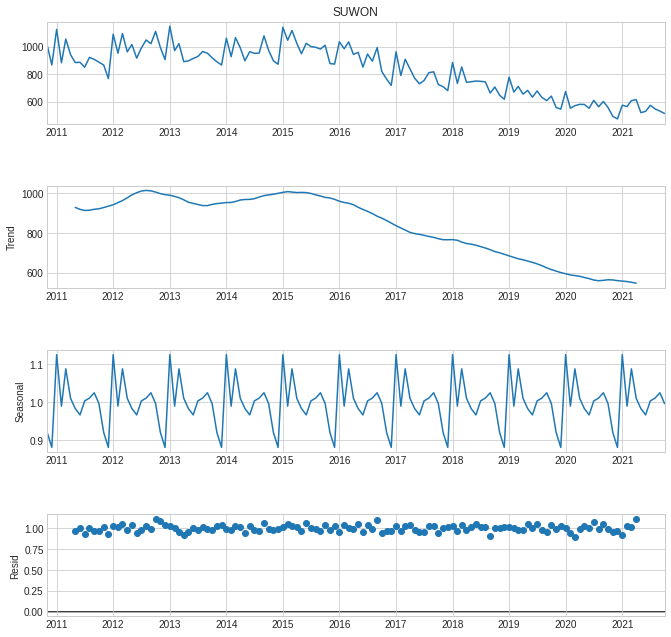

In [ ]:
decomposition = sm.tsa.seasonal_decompose(SUWON, model = 'multiplicative')
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

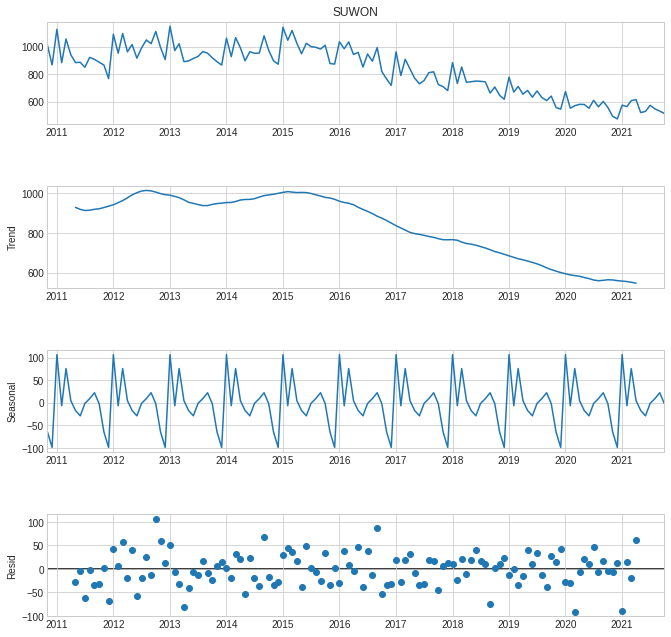

In [ ]:
decomposition = sm.tsa.seasonal_decompose(SUWON, model = 'additive')
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [ ]:
train_data, test_data = train_test_split(SUWON, test_size=0.2, shuffle = False)

* **ACF** (Auto-Correlation Function) &  **PACF** (Partial Auto-Correlation Function) Test

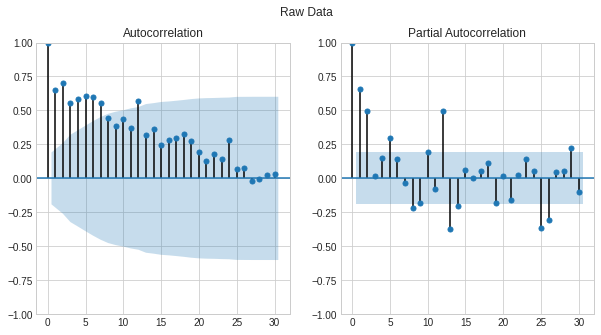

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]);

정상성을 나타내지 않는 데이터에서는 ACF가 느리게 감소하지만, 정상성을 나타내는 시계열에서는, ACF가 비교적 빠르게 0으로 떨어짐

* **ADF** (Augmented Dickey-Fuller) Test

In [ ]:
def adf_test(df):
    result = adfuller(df.values)
    print('ADF S: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
      print('\t%s: %.3f' % (key,value))

print('ADF Test')
adf_test(train_data)

ADF Test
ADF S: 0.302292
p-value: 0.977449
Critical values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


시계열 표본에 단위근이 존재한다는 귀무 가설을 검정

* **KPSS** (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [ ]:
def kpss_test(df):
  statistic, p_value, n_lags, critical_values = kpss(df.values)

  print(f'KPSS Statistic: {statistic}')
  print(f'p-value: {p_value}')
  print(f'num lags: {n_lags}')
  print('Critial Values:')
  for key,value in critical_values.items():
    print(f'  {key} : {value}')

print('KPSS TEST')
kpss_test(train_data)

KPSS TEST
KPSS Statistic: 1.2394568366376586
p-value: 0.01
num lags: 5
Critial Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2012: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


# Stationarity & Differencing
* 차분은 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만들 수 있음
* 결과적으로 추세나 계절성이 제거(또는 감소)

In [ ]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.diff()
diff_train_data = diff_train_data.dropna()
print(train_data)
print(diff_train_data)

TIME
2010-11-01    1010
2010-12-01     867
2011-01-01    1125
2011-02-01     883
2011-03-01    1055
              ... 
2019-03-01     711
2019-04-01     655
2019-05-01     682
2019-06-01     633
2019-07-01     678
Name: SUWON, Length: 105, dtype: int64
TIME
2010-12-01   -143.0
2011-01-01    258.0
2011-02-01   -242.0
2011-03-01    172.0
2011-04-01   -114.0
              ...  
2019-03-01     41.0
2019-04-01    -56.0
2019-05-01     27.0
2019-06-01    -49.0
2019-07-01     45.0
Name: SUWON, Length: 104, dtype: float64


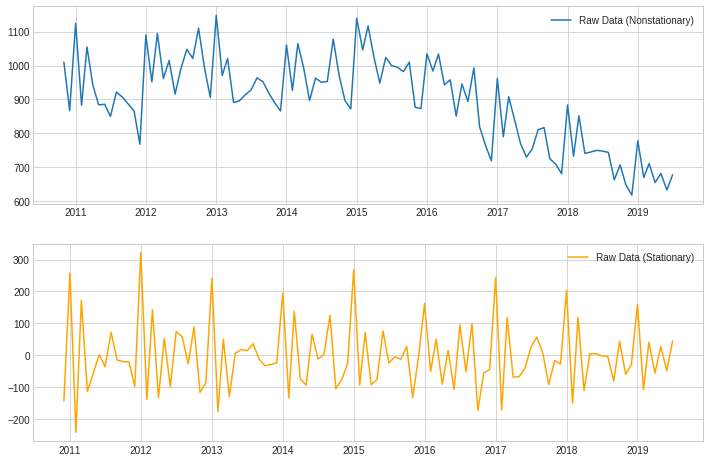

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data)
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data,'orange')
plt.legend(['Raw Data (Stationary)'])
plt.show()

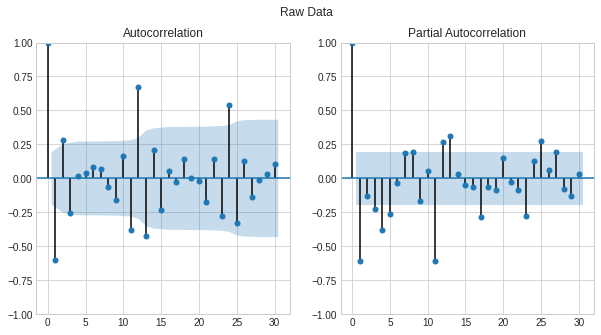

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]);

In [ ]:
print('ADF Test[Differencing]')
adf_test(diff_train_data)
print('\n')
print('KPSS TEST[Differencing]')
kpss_test(diff_train_data)

ADF Test[Differencing]
ADF S: -2.659543
p-value: 0.081305
Critical values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


KPSS TEST[Differencing]
KPSS Statistic: 0.026359769936935007
p-value: 0.1
num lags: 1
Critial Values:
  10% : 0.347
  5% : 0.463
  2.5% : 0.574
  1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2016: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


# ARIMA
* ARIMA(p,d,q) : d차 차분한 데이터에 AR(p)모형과 MA(q)모형을 합친 모형

In [ ]:
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic =[]
for i in pdq:
  model = ARIMA(train_data.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic,2))

ARIMA: (0, 1, 0) >> AIC : 1267.49
ARIMA: (0, 1, 1) >> AIC : 1215.31
ARIMA: (0, 1, 2) >> AIC : 1216.22
ARIMA: (1, 1, 0) >> AIC : 1222.76
ARIMA: (1, 1, 1) >> AIC : 1215.78


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA: (1, 1, 2) >> AIC : 1207.94
ARIMA: (2, 1, 0) >> AIC : 1223.72
ARIMA: (2, 1, 1) >> AIC : 1215.26
ARIMA: (2, 1, 2) >> AIC : 1215.65


In [ ]:
optimal = [(pdq[i], j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((1, 1, 2), 1207.94)]

In [ ]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -599.972
Date:                Wed, 17 Nov 2021   AIC                           1207.944
Time:                        00:30:13   BIC                           1218.522
Sample:                             0   HQIC                          1212.230
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.001   -949.219      0.000      -1.002      -0.998
ma.L1          0.2863      0.184      1.553      0.120      -0.075       0.647
ma.L2         -0.7121      0.122     -5.835      0.000      -0.951      -0.473
sigma2      5817.8311   4.28e-05   1.36e+08      0.000    5817.831    5817.831
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.89   Prob(JB):                         0.26
Heteroskedasticity (H):               0.70   Skew:                             0.39
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+23. Standard errors may be unstable.
"""

# auto_arima

In [ ]:
arima_model = auto_arima(train_data, start_p=1, start_q=1,
                        max_p=3, max_q=3, m=12, seasonal = False,
                        d=1, D=1,
                        max_P=3, max_Q=3,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1269.391, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1215.139, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1216.260, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1213.555, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1224.464, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1215.895, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1213.940, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1225.332, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1215.182, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1221.771, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1212.323, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1192.474, Time=0.43 sec

Best model:  ARIMA(3,1,2

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -589.237
Date:                Wed, 17 Nov 2021   AIC                           1192.474
Time:                        00:30:17   BIC                           1210.985
Sample:                             0   HQIC                          1199.974
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -5.6412      6.948     -0.812      0.417     -19.259       7.977
ar.L1          0.2776      0.086      3.222      0.001       0.109       0.447
ar.L2         -0.2591      0.079     -3.283      0.001      -0.414      -0.104
ar.L3         -0.6984      0.084     -8.281      0.000      -0.864      -0.533
ma.L1         -1.0896      0.069    -15.814      0.000      -1.225      -0.955
ma.L2          0.9203      0.088     10.509      0.000       0.749       1.092
sigma2      4702.4507    730.591      6.436      0.000    3270.518    6134.384
===================================================================================
Ljung-Box (L1) (Q):                   2.29   Jarque-Bera (JB):                10.87
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.74
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

RMSE_ARIMA = np.sqrt(mean_squared_error(test_data, predicted_value))
MAE_ARIMA = mean_absolute_error(test_data, predicted_value)

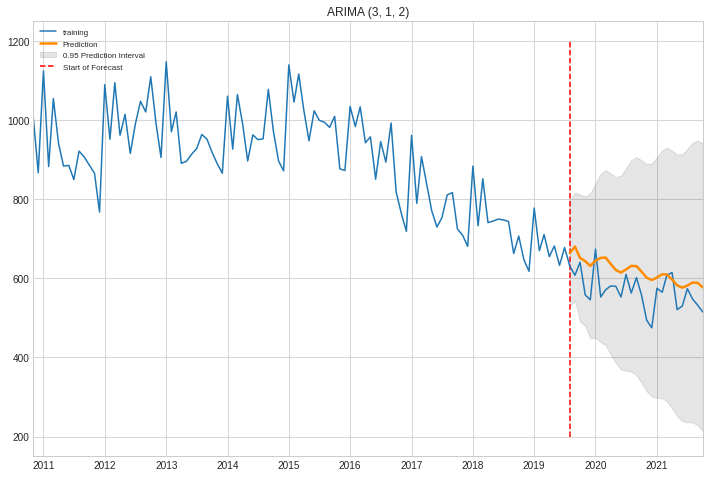

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(SUWON, label='training')
plt.plot(predict_index, predicted_value, color = 'darkorange', label = 'Prediction', linewidth = 2.5)
plt.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label ='0.95 Prediction Interval')
plt.vlines(predict_index[0], 200, 1200, linestyle='--', color='r', label='Start of Forecast')
plt.title(f'ARIMA {arima_model.order}')
plt.xlim(SUWON.index[0],SUWON.index[-1])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# SARIMA
* ARIMA 모델에 계절성(Seasional)이 추가된 모델

In [ ]:
sarima_model = auto_arima(train_data, start_p=1, start_q=1,
                        max_p=3, max_q=3, m=12, seasonal = True,
                        d=1, D=1,
                        max_P=3, max_Q=3,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1056.491, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1025.399, Time=0.19 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1027.333, Time=0.79 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=1027.753, Time=1.74 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1041.358, Time=0.12 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1027.354, Time=0.30 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1027.919, Time=1.13 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1024.980, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1026.918, Time=0.82 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=1026.936, Time=0.83 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=3.91 sec
 ARIMA(0,1,1)(0,1,0)

In [ ]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -494.442
Date:                            Wed, 17 Nov 2021   AIC                            996.884
Time:                                    00:32:26   BIC                           1006.971
Sample:                                         0   HQIC                          1000.955
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5316      0.094     -5.632      0.000      -0.717      -0.347
ar.S.L12      -0.6895      0.114     -6.027      0.000      -0.914      -0.465
ar.S.L24      -0.4741      0.116     -4.102      0.000      -0.701      -0.248
sigma2      2465.4029    433.824      5.683      0.000    1615.123    3315.683
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.52   Prob(JB):                         0.69
Heteroskedasticity (H):               0.73   Skew:                            -0.03
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = sarima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)

RMSE_SARIMA = np.sqrt(mean_squared_error(test_data, predicted_value))
MAE_SARIMA = mean_absolute_error(test_data, predicted_value)

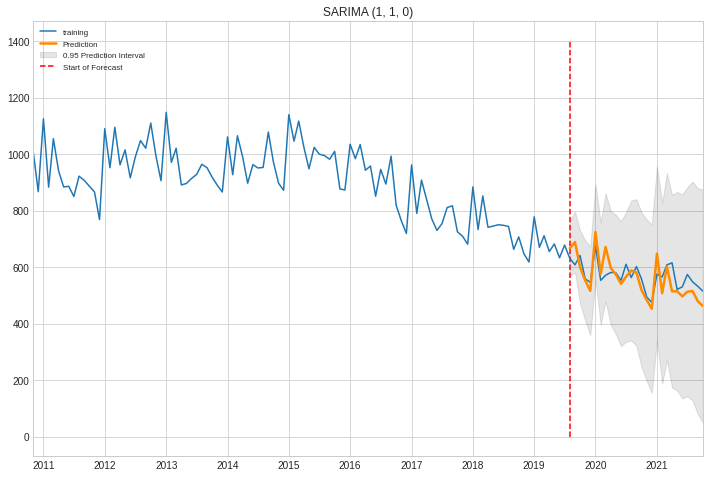

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(SUWON, label='training')
plt.plot(predict_index, predicted_value, color = 'darkorange', label = 'Prediction', linewidth = 2.5)
plt.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label ='0.95 Prediction Interval')
plt.vlines(predict_index[0], 0, 1400, linestyle='--', color='r', label='Start of Forecast')
plt.title(f'SARIMA {sarima_model.order}')
plt.xlim(SUWON.index[0],SUWON.index[-1])
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Holt-Winters Exponentional Smoothing

In [ ]:
train_data.index.freq = 'MS'
test_data.index.freq = 'MS'

fitted_model = ExponentialSmoothing(train_data,trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(27)

RMSE_HWES = np.sqrt(mean_squared_error(test_data,test_predictions))
MAE_HWES = mean_absolute_error(test_data, test_predictions)

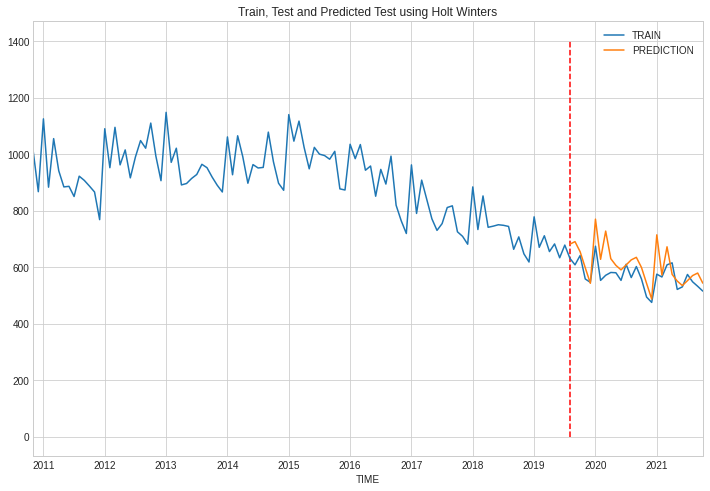

In [ ]:
SUWON.plot(legend=True,label='TRAIN',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.vlines(predict_index[0], 0, 1400, linestyle='--', color='r', label='Start of Forecast')
plt.title('Train, Test and Predicted Test using Holt Winters');

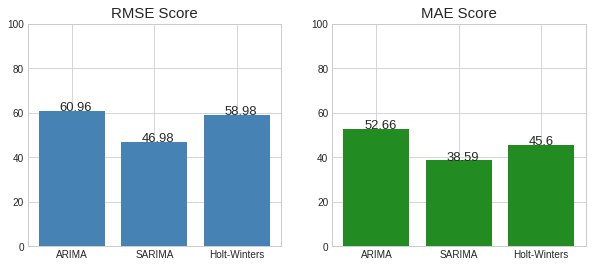

In [ ]:
rmse_score = [RMSE_ARIMA, RMSE_SARIMA, RMSE_HWES]
x_lab = ['ARIMA', 'SARIMA', 'Holt-Winters']
plt.figure(figsize=(10,9))
plt.subplot(2,2,1)
plt.bar(x_lab, rmse_score, color = 'steelblue')
plt.title('RMSE Score', fontsize=15)
plt.ylim(0,100)
for i, v in enumerate(rmse_score):
    plt.text(i-0.15, v + 0.002, str(np.round(v,2)),fontsize=13)

MAE_score = [MAE_ARIMA, MAE_SARIMA, MAE_HWES]
x_lab = ['ARIMA', 'SARIMA', 'Holt-Winters']
plt.subplot(2,2,2)
plt.bar(x_lab, MAE_score, color = 'forestgreen')
plt.title('MAE Score', fontsize=15)
plt.ylim(0,100)
for i, v in enumerate(MAE_score):
    plt.text(i-0.15, v + 0.002, str(np.round(v,2)),fontsize=13)

# ARIMA.update

In [ ]:
date = test_data.index[-1] + MonthBegin()
date = pd.date_range(date, periods = 38, freq = pd.offsets.MonthBegin())

sarima_model.update(test_data)
new_preds, new_conf_int = sarima_model.predict(n_periods=38, return_conf_int=True)

predict = pd.DataFrame(new_preds, index = date, columns=['SUWON'])
predict.to_csv('CHILD_SUWON_Pred.csv')